In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Reading data from csv
train = pd.read_csv("/content/drive/MyDrive/fake_news_project/train.csv",engine="python",error_bad_lines=False)
test  = pd.read_csv("/content/drive/MyDrive/fake_news_project/test.csv",engine="python",error_bad_lines=False)
train.head()

Skipping line 13535: field larger than field limit (131072)
Skipping line 19783: field larger than field limit (131072)
Skipping line 13541: Expected 5 fields in line 13541, saw 6
Skipping line 19782: Expected 5 fields in line 19782, saw 7
Skipping line 19783: Expected 5 fields in line 19783, saw 10
Skipping line 19785: Expected 5 fields in line 19785, saw 14
Skipping line 19787: Expected 5 fields in line 19787, saw 8
Skipping line 19789: Expected 5 fields in line 19789, saw 7
Skipping line 19790: Expected 5 fields in line 19790, saw 15
Skipping line 19791: Expected 5 fields in line 19791, saw 9
Skipping line 19792: Expected 5 fields in line 19792, saw 9
Skipping line 19793: Expected 5 fields in line 19793, saw 12
Skipping line 19794: Expected 5 fields in line 19794, saw 15
Skipping line 19795: Expected 5 fields in line 19795, saw 8
Skipping line 19796: Expected 5 fields in line 19796, saw 20
Skipping line 19797: Expected 5 fields in line 19797, saw 8
Skipping line 19798: Expected 5 fi

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [ ]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(train.shape[0],train.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test.shape[0],test.shape[1]))

There are 20822 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


Data Preprocessing

In [ ]:
# Checking the null values in training data.
train.isnull().sum()

id           0
title      565
author    1975
text        59
label       22
dtype: int64

In [ ]:
# Checking the null values in testing data.
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [ ]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(train,test)

In [ ]:
train.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

In [ ]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [ ]:
# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

NLP preprocessing methods

In [ ]:
# Performing data preprocessing on column 'title'
from nltk.stem import WordNetLemmatizer
ps = WordNetLemmatizer()
def perform_preprocess(data):
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.lemmatize(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillary clinton big woman campus breitbart daniel j flynn'

In [ ]:
test_corpus[1]

'russian warship ready strike terrorist near aleppo'

Below code converts the pre-processed words to one-hot vectors in the range of vocabulary size=5000. This is done to obtain numerical feature matrix

In [ ]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [ ]:
one_hot_test[1]

[721, 2523, 590, 3520, 3008, 3687, 341]

Below code creates an embedding layer which applies "pre" padding to the one-hot encoded features with sentence length = 20. Padding is applied so that the length of every sequence in the dataset should be same

In [ ]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 2451 1509 4984]
 [   0    0    0 ... 3383 2227 1183]
 [   0    0    0 ... 2619 4306 2211]
 ...
 [   0    0    0 ...  755 2991 2323]
 [   0    0    0 ...  424 2691 2538]
 [   0    0    0 ... 2668 1371  308]]


In [ ]:
print(embedd_docs_test)

[[   0    0    0 ...  368 1371  451]
 [   0    0    0 ... 3008 3687  341]
 [   0    0    0 ... 4502 3388 2322]
 ...
 [   0    0    0 ...  368 2622 2846]
 [   0    0    0 ...  721 2865 1620]
 [   0    0    0 ...  368 1306 3292]]


In [ ]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [ ]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20822, 20), (20822,), (5200, 20))

Dividing the dataset into training,validation and testing data (ratio: 80/10/10) using train_test_split technique.

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_test_final = x_test_final

Models

1. Logistic Regresssion

In [ ]:
model_1 = LogisticRegression(max_iter=500)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

                                                  precision    recall  f1-score   support

                                                       0.00      0.00      0.00         3
 чтобы это была дорога с двусторонним движением.       0.00      0.00      0.00         1
                                               0       0.75      0.78      0.77      1042
                                               1       0.77      0.74      0.75      1037

                                        accuracy                           0.76      2083
                                       macro avg       0.38      0.38      0.38      2083
                                    weighted avg       0.76      0.76      0.76      2083



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


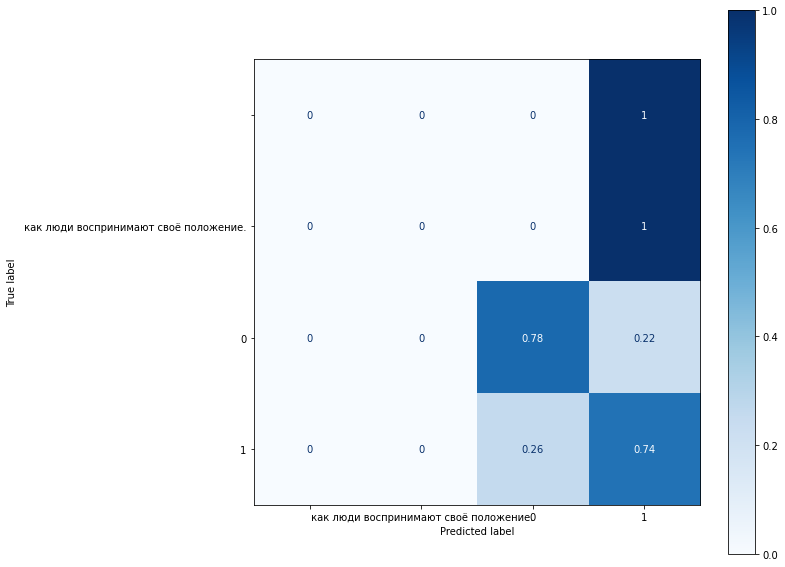

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, pred_1, labels=train['label'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_1, x_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

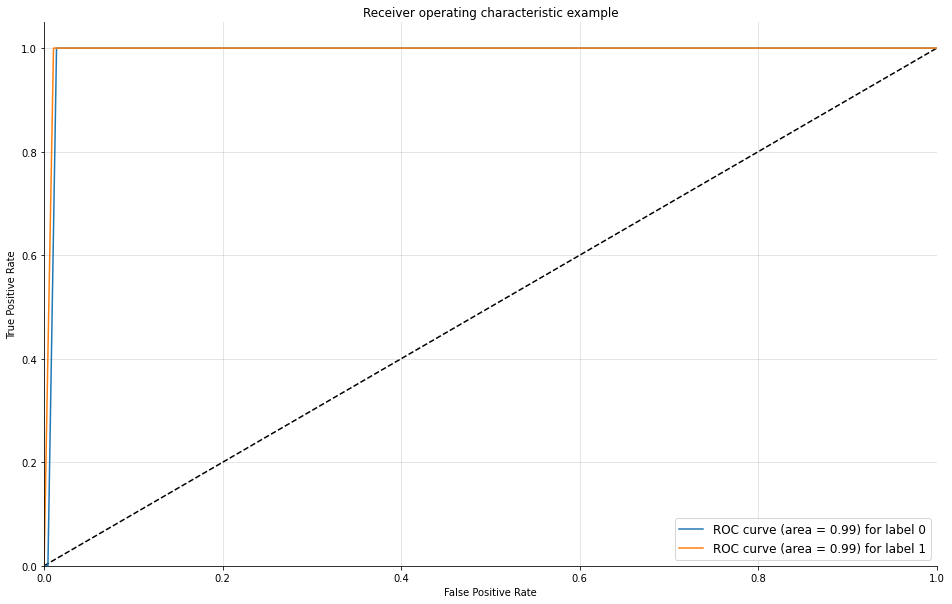

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test) #

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best", prop={"size":12})
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_1, x_test, y_test, n_classes=2, figsize=(16, 10))

2. Naive Bayes

In [ ]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                  precision    recall  f1-score   support

                                                       0.00      0.00      0.00         3
           как люди воспринимают своё положение.       0.00      0.00      0.00         0
 чтобы это была дорога с двусторонним движением.       0.00      0.00      0.00         1
                                               0       0.79      0.63      0.70      1042
                                               1       0.72      0.73      0.73      1037

                                        accuracy                           0.68      2083
                                       macro avg       0.30      0.27      0.29      2083
                                    weighted avg       0.75      0.68      0.71      2083



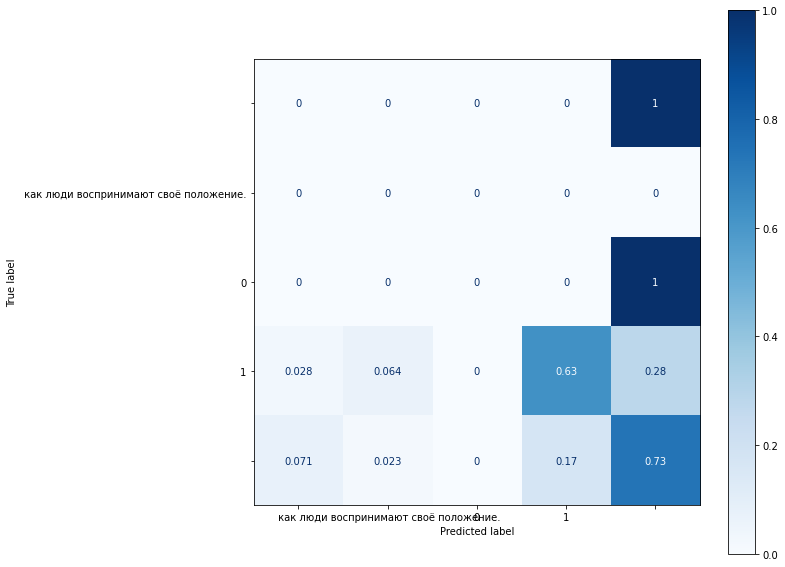

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, pred_2, labels=train['label'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_2, x_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

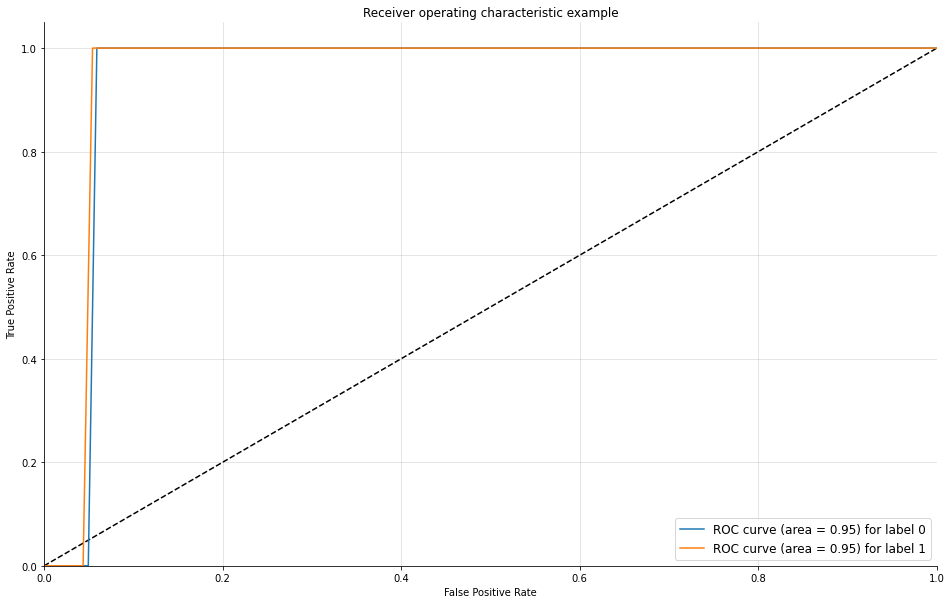

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test) #

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best", prop={"size":12})
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_2, x_test, y_test, n_classes=2, figsize=(16, 10))

3.Decision Tree

In [ ]:
from sklearn import tree
model_3 = tree.DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

                                                  precision    recall  f1-score   support

                                                       0.00      0.00      0.00         3
 чтобы это была дорога с двусторонним движением.       0.00      0.00      0.00         1
                                               0       0.94      0.95      0.94      1042
                                               1       0.94      0.93      0.94      1037

                                        accuracy                           0.94      2083
                                       macro avg       0.47      0.47      0.47      2083
                                    weighted avg       0.94      0.94      0.94      2083



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


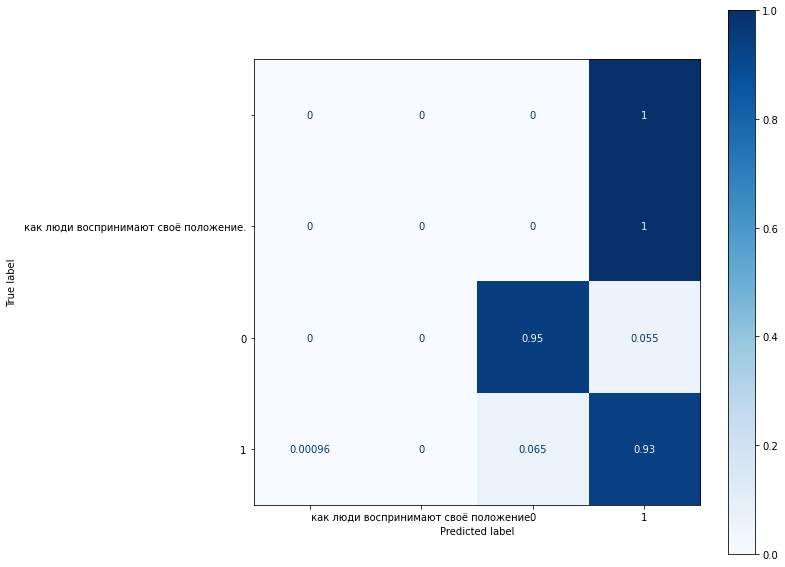

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, pred_3, labels=train['label'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_3, x_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

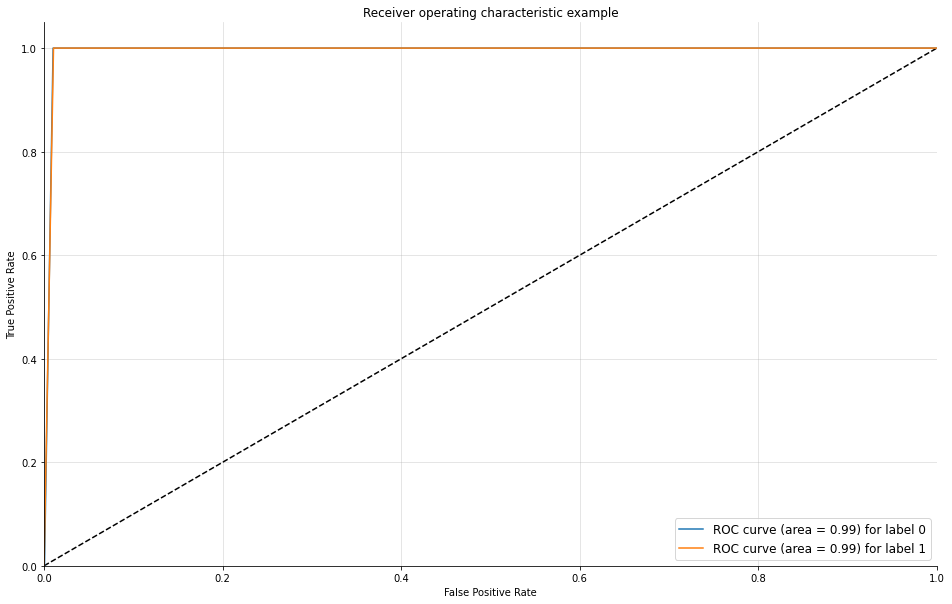

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test) #

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best", prop={"size":12})
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_3, x_test, y_test, n_classes=2, figsize=(16, 10))

4. Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC
model_4 = SVC(probability=True)
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

                                                  precision    recall  f1-score   support

                                                       0.00      0.00      0.00         3
 чтобы это была дорога с двусторонним движением.       0.00      0.00      0.00         1
                                               0       0.84      0.83      0.84      1042
                                               1       0.83      0.84      0.83      1037

                                        accuracy                           0.83      2083
                                       macro avg       0.42      0.42      0.42      2083
                                    weighted avg       0.83      0.83      0.83      2083



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


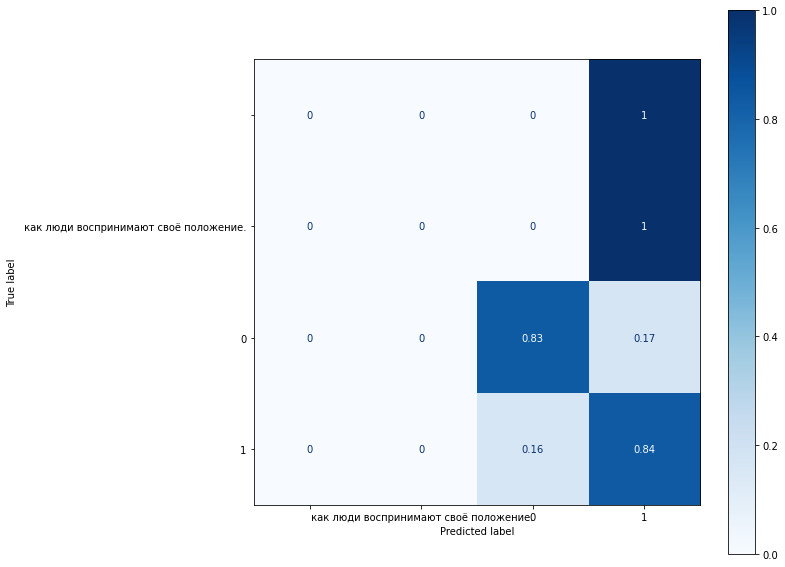

In [ ]:
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_test, pred_4, labels=train['label'].unique())

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_4, x_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

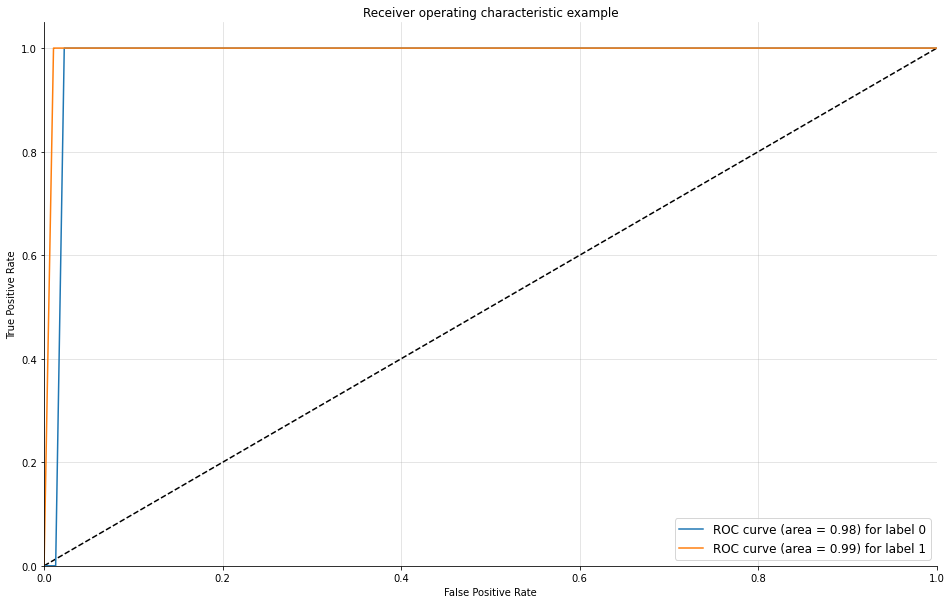

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test) #

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best", prop={"size":12})
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(model_4, x_test, y_test, n_classes=2, figsize=(16, 10))

Evaluation of Models

In [ ]:

score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)

In [ ]:
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],["SVM",score_4]],columns=["Model","Accuracy"])
results

,Model,Accuracy
0,Logistic Regression,0.759482
1,Naive Bayes,0.679789
2,Decision Tree,0.938070
3,SVM,0.833893


Predictions on Testing Data

In [ ]:
# Making Predictions on test data
predictions_test = pd.DataFrame(model_3.predict(x_test_final))
test_id = pd.DataFrame(test["id"])
submission = pd.concat([test_id,predictions_test],axis=1)
submission.columns = ["id","label"]
submission.to_csv("Submission.csv",index=False)

In [ ]:
submission.head(10)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,0
6,20806,0
7,20807,1
8,20808,1
9,20809,1
